In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import kstest
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, AdaBoostRegressor
from sklearn.neighbors import LocalOutlierFactor
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
import graphviz

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

In [33]:
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)

sns.set_style('white')#设置绘图风格
sns.set_context('notebook')

In [34]:
# 导入i3e数据
i3e_data = pd.read_csv('/Users/han/Desktop/Dissertation/Heating-System-Analysis/i3e_data_ex.csv')
i3e_data.head()

,Date,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",USPD,YYYYMM,registrated,scheme,type,area,floors,walls material,year of construction,area of building,"temp,˚C"
0,2013/12/1,93.95,84.17,9.78,65.86,43.56,22.30,2.10,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-0.157917
1,2013/12/2,91.28,81.69,9.59,65.18,42.87,22.31,2.04,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-1.259167
2,2013/12/3,91.76,84.87,6.90,65.70,43.17,22.53,2.07,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-4.739167
3,2013/12/4,88.79,79.92,8.87,65.26,42.23,23.03,2.05,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-1.216250
4,2013/12/5,89.37,81.50,7.87,65.47,42.22,23.25,2.08,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-0.533750


## Data Description
|serial|name|description|type|
|:--:|:--:|--|:--:|
| (A)| Date |date in Windows format.|Date
| (B)| M1, t |mass of the input water (heat carrier) per day.|Ratio
| (C)| М2, t |mass of the output water. If the residential building has the open heating system (hot water is flowed from the heating system), (C) less than (B).|Ratio
| (D)| ΔМ, t |difference in volumes (C)-(B). For buildings with the opened heating system this is the data for analysis. In closed system it is the technological parameter allows observation for equipment.|Ratio
| (E)| Т1, °C |average temperature of the heating carrier in the input of the heating system. It is the independent variable from home characteristics.|Interval
| (F)| Т2, °C |average temperature of the heating carrier in the output. It is the dependent variable both from (E) and heating consumption at building.|Interval
| (G)| ΔТ, °C |temperature difference, (F)-(E).|Interval
| (H)| Q, Gcal |amount of the consumed heating in Gcal. It is calculated by formula (H)=(B)*[(E)-(F)].|Ratio
| (I)| USPD |ID of the heating meter. Some residential buildings have many heating meters.|Nominal
| (J)| YYYYMM |date in the format year-month YYYYMM.|Date
| (K)| registrated |what is registrated, heating or heating plus hot water.|Nominal
| (L)| scheme |type of the heating system (opened or closed).|Nominal
| (M)| type |code system-load (4 digits). First digit 1 is opened system, 2 is closed system. The second digit 0 is heating, 1 is heating and hot water supply. The third and fourth digits is floors amount (01, 02, 03, ..., 17).  M = L + K + O|Nominal
| (N)| area |area of building that heating meter is served.|Ratio
| (O)| floors |amount of building floors. 定序|Ordinal
| (P)| walls material |walls material.|Nominal
| (Q)| year of construction |year of building construction.|Date
| (R)| area of building |total area of building.|Ratio
| (S)| temp,˚C |outdoor temperature.|Interval

In [35]:
i3e_data.describe()


,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",USPD,YYYYMM,type,area,floors,year of construction,area of building,"temp,˚C"
count,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000
mean,125.850469,122.223893,3.626447,75.421842,49.523286,25.898602,3.179756,14.026043,201533.466968,1695.796581,3438.056878,5.962494,1975.494922,4247.011376,-5.686209
std,67.795961,67.966234,6.612460,10.088915,5.910461,6.649766,1.409529,7.247675,116.006216,492.220525,1457.208563,1.709934,6.692790,1532.176056,10.009065
min,30.740000,29.800000,-7.680000,44.280000,26.710000,2.020000,0.190000,1.000000,201312.000000,1105.000000,1983.460000,5.000000,1964.000000,2729.700000,-33.521342
25%,97.850000,89.710000,-0.830000,66.830000,45.500000,21.350000,2.390000,7.000000,201410.000000,1105.000000,2707.400000,5.000000,1968.000000,3382.250000,-12.426033
50%,117.570000,114.680000,2.110000,73.510000,49.130000,25.270000,2.980000,17.000000,201510.000000,2105.000000,3234.450000,5.000000,1976.000000,4319.650000,-5.011250
75%,143.660000,142.100000,6.430000,82.520000,53.280000,30.190000,3.720000,20.000000,201610.000000,2105.000000,3512.700000,5.000000,1982.000000,4737.000000,1.225254
max,1006.900000,984.670000,118.990000,104.860000,76.470000,56.780000,23.500000,24.000000,201709.000000,2109.000000,18801.100000,9.000000,1988.000000,21000.000000,20.010833


In [36]:
M1 = i3e_data["М1, t"]
M2 = i3e_data["М2, t"]
delta_M = i3e_data["ΔМ, t"]
T1 = i3e_data["Т1, °C"]
T2 = i3e_data["Т2, °C"]
delta_T = i3e_data["ΔТ, °C"]
area_of_building = i3e_data["area of building"]
Gcal = i3e_data["Q, Gcal"]

area = i3e_data["area"]
year_of_construction = i3e_data["year of construction"]
temp = i3e_data["temp,˚C"]
type = i3e_data["type"]

registrated = i3e_data["registrated"]
floors = i3e_data["floors"]
walls_material = i3e_data["walls material"]
scheme = i3e_data["scheme"]



In [37]:
data= i3e_data[['М1, t', 'М2, t', 'ΔМ, t', 'ΔТ, °C', 'Т1, °C', 'Т2, °C', 'Q, Gcal', 'Date', 'area of building', 'USPD', 'registrated', 'scheme', 'area', 'floors',
                'walls material', 'year of construction', 'temp,˚C']]
data.describe()

,"М1, t","М2, t","ΔМ, t","ΔТ, °C","Т1, °C","Т2, °C","Q, Gcal",area of building,USPD,area,floors,year of construction,"temp,˚C"
count,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000,9945.000000
mean,125.850469,122.223893,3.626447,25.898602,75.421842,49.523286,3.179756,4247.011376,14.026043,3438.056878,5.962494,1975.494922,-5.686209
std,67.795961,67.966234,6.612460,6.649766,10.088915,5.910461,1.409529,1532.176056,7.247675,1457.208563,1.709934,6.692790,10.009065
min,30.740000,29.800000,-7.680000,2.020000,44.280000,26.710000,0.190000,2729.700000,1.000000,1983.460000,5.000000,1964.000000,-33.521342
25%,97.850000,89.710000,-0.830000,21.350000,66.830000,45.500000,2.390000,3382.250000,7.000000,2707.400000,5.000000,1968.000000,-12.426033
50%,117.570000,114.680000,2.110000,25.270000,73.510000,49.130000,2.980000,4319.650000,17.000000,3234.450000,5.000000,1976.000000,-5.011250
75%,143.660000,142.100000,6.430000,30.190000,82.520000,53.280000,3.720000,4737.000000,20.000000,3512.700000,5.000000,1982.000000,1.225254
max,1006.900000,984.670000,118.990000,56.780000,104.860000,76.470000,23.500000,21000.000000,24.000000,18801.100000,9.000000,1988.000000,20.010833


/Users/han/opt/anaconda3/envs/Course1/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/han/opt/anaconda3/envs/Course1/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


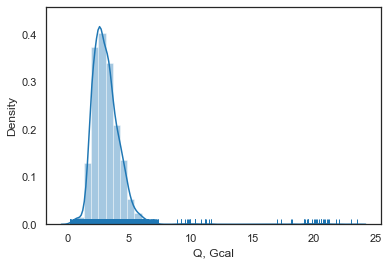

In [38]:
sns.distplot(data['Q, Gcal'], bins=40, hist=True,#是否绘制直方图
            kde=True,#是否绘制密度图
            rug=True,
            axlabel='Q, Gcal')
plt.show()

/Users/han/opt/anaconda3/envs/Course1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


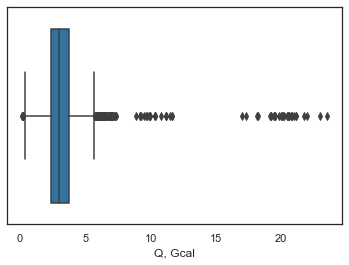

In [39]:
sns.boxplot(data['Q, Gcal'])
plt.show()


In [40]:
#sns.pairplot(data)
#plt.show()


**没有缺失值，接下来排除异常值**

##### 尝试3sigma原则发现删除的数据过多,因为大多数数据不符合正态分布

### 对数据进行KS检验
#### K-S检验的原假设是“样本数据来自的分布与正态分布无显著差异”，因此一般来说，检验结果P>0.05才是我们的目标

In [41]:
KS_list=[M1, M2, delta_M, T1, T2, delta_T, area_of_building, temp, Gcal]
def KStest(data):
    temp_list=[]
    test_stat_list=[]
    for i, value in enumerate(data):
        test_stat, pvalue= kstest(value, 'norm', args=(), alternative='two-sided', mode='approx')
        temp_list.insert(i, pvalue)
        test_stat_list.insert(i, test_stat)
    return "p-value", temp_list, "test_stat:" , test_stat_list
KStest(KS_list) 

('p-value',
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'test_stat:',
 [1.0,
  1.0,
  0.5017476276873385,
  1.0,
  1.0,
  0.9992493802417155,
  1.0,
  0.5996143092266654,
  0.9230862629238252])

#### 数据不符合正态分布 Turkey's Test
#### Percentile = np.percentile(df['length'],[0,25,50,75,100])
#### IQR = Percentile[3] - Percentile[1]
#### UpLimit = Percentile[3]+ageIQR*1.5
#### DownLimit = Percentile[1]-ageIQR*1.5
#### 四分位距(IQR)就是上四分位与下四分位的差值。而我们通过IQR的1.5倍为标准，规定：超过上四分位+1.5倍IQR距离，或者下四分位-1.5倍IQR距离的点为异常值

/Users/han/opt/anaconda3/envs/Course1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


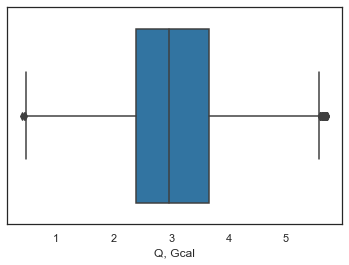

'\ni3e_data = i3e_data.drop(data_drop_M1.index)\ni3e_data.describe()\n'

In [42]:
Percentile = np.percentile(data['Q, Gcal'],[0,25,50,75,100])
IQR = Percentile[3] - Percentile[1]
UpLimit = Percentile[3] + IQR*1.5
DownLimit = Percentile[1] - IQR*1.5
data=data[(data['Q, Gcal']< UpLimit )&(data['Q, Gcal'] > DownLimit)]
sns.boxplot(data['Q, Gcal'])
plt.show()

'''
M1.values
mean_M1 = M1.mean()
std_M1 = M1.std()
error = i3e_data[np.abs(M1-mean_M1) > 3*std_M1]
# 剔除异常值，保留正常的数据
data_drop_M1 = i3e_data[np.abs(M1 - mean_M1) <= 3*std_M1]
data_drop_M1.describe()
'''
'''
i3e_data = i3e_data.drop(data_drop_M1.index)
i3e_data.describe()
'''

/Users/han/opt/anaconda3/envs/Course1/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: No contour levels were found within the data range.
/Users/han/opt/anaconda3/envs/Course1/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: No contour levels were found within the data range.
/Users/han/opt/anaconda3/envs/Course1/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: No contour levels were found within the data range.
/Users/han/opt/anaconda3/envs/Course1/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: No contour levels were found within the data range.


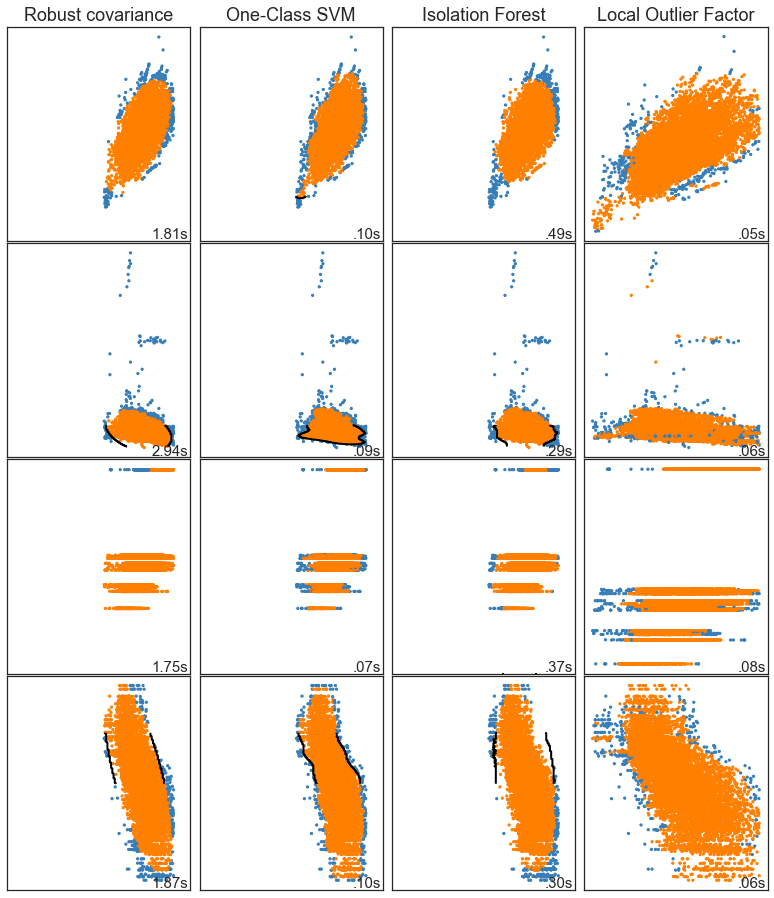

In [43]:
#比较几种异常值剔除方法

outliers_fraction = 0.03

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]
pd1 = data[['Q, Gcal', 'ΔТ, °C']].values
pd2 = data[['Q, Gcal', 'ΔМ, t']].values
pd3 = data[['Q, Gcal', 'area']].values
pd5 = data[['Q, Gcal', 'temp,˚C']].values
# Define datasets
datasets = [pd1, pd2, pd3, pd5]
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))
plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1
rng = np.random.RandomState(42)
for i_dataset, dataset in enumerate(datasets):
    # Add outliers
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(dataset)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(dataset)
        else:
            y_pred = algorithm.fit(dataset).predict(dataset)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(dataset[0:, 0], dataset[0:, 1], s=5, color=colors[(y_pred + 1) // 2])

        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [44]:
#使用Isolation Forest进行离群点排除
clf= IsolationForest(contamination=outliers_fraction, random_state=42)
clf.fit(data[['Q, Gcal']])
data['anomaly']=clf.predict(data[['Q, Gcal']])
data=data.drop(data[data['anomaly']==-1].index)
data = data.drop(columns=['anomaly'])

### 特征进行筛选
* delta_M = M2 - M1 三者存在高度线性相关，所以只保留delta_M
* delta_T = T2 - T1 三者存在高度线性相关，所以只保留delta_T
* M = L + K + O 去除M，保留K，L，O
* 存在日期，去除J

#### 对类别变量进行编码 category encoders
#### 分类变量包括 K，L，O，P
#### 对分类数据进行OneHot编码
#### 先用 LabelEncoder() 转换成连续的数值型变量
#### 基于树的方法是不需要进行特征的归一化，例如随机森林，bagging 和 boosting等。基于参数的模型或基于距离的模型，都是要进行特征的归一化

In [45]:
id_data = data[['USPD', 'registrated', 'scheme', 'walls material']].values[:, :1]
transform_data=data[['USPD', 'registrated', 'scheme','walls material']].values[:, 1:]

#先用 LabelEncoder() 转换成连续的数值型变量
a = LabelEncoder().fit_transform(data['scheme'])
#再用 OneHotEncoder() 二值化
df1 =OneHotEncoder().fit_transform(a.reshape(-1, 1)).toarray() # 注意: 这里把 a 用 reshape 转换成 2-D array

b = LabelEncoder().fit_transform(data['registrated'])
df2 = OneHotEncoder().fit_transform(b.reshape(-1,1)).toarray()
#data['USPD']=OneHotEncoder(sparse = False).fit_transform(data[['USPD']])

c = LabelEncoder().fit_transform(data['walls material'])
df3 = OneHotEncoder().fit_transform(c.reshape(-1,1)).toarray()

df4 = OneHotEncoder().fit_transform(data['USPD'].values.reshape(-1,1)).toarray()

df_x=np.concatenate([df1,df2,df3,df4],axis=-1)

df_OneHot =pd.DataFrame(df_x)
data_OneHot = data.drop(columns=['USPD', 'registrated', 'scheme', 'walls material'])

# data_OneHot2 = pd.concat([data_OneHot, df_OneHot], axis=1)

for item in df_OneHot.columns:
    print(item)
    data_OneHot[str(item)]=df_OneHot[item].values

# data_OneHot = data_OneHot.join(df_OneHot)
print(data_OneHot.describe())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
             М1, t        М2, t        ΔМ, t       ΔТ, °C       Т1, °C  \
count  9441.000000  9441.000000  9441.000000  9441.000000  9441.000000   
mean    120.708187   117.067929     3.640140    25.892618    75.151371   
std      30.859509    33.186743     6.592641     6.344263     9.599949   
min      40.230000    29.800000    -7.680000     7.200000    53.610000   
25%      97.850000    89.530000    -0.850000    21.440000    66.940000   
50%     116.720000   113.920000     2.160000    25.190000    73.270000   
75%     139.880000   138.690000     6.510000    29.830000    81.620000   
max     269.800000   276.600000   118.990000    56.780000   104.860000   

            Т2, °C      Q, Gcal  area of building         area       floors  \
count  9441.000000  9441.000000       9441.000000  9441.000000  9441.000000   
mean     49.258811     3.062584       4115.390261  3311.797482     5.933376   
std       5.687352     0.852959        922.

In [46]:
#树模型不需要OneHot编码，所以用LabelEncoder进行编码
c = LabelEncoder().fit_transform(data['scheme'])
df_scheme = pd.DataFrame(c)
df_scheme.columns=['scheme']

c = LabelEncoder().fit_transform(data['USPD'])
df_USPD = pd.DataFrame(c)
df_USPD.columns=['USPD']

c = LabelEncoder().fit_transform(data['walls material'])
df_wallsMaterial = pd.DataFrame(c)
df_wallsMaterial.columns=['walls materials']

c = LabelEncoder().fit_transform(data['registrated'])
df_registered = pd.DataFrame(c)
df_registered.columns=['registrated']

df_x=np.concatenate([df_scheme,df_wallsMaterial,df_registered,df_USPD],axis=-1)

df_Label =pd.DataFrame(df_x)
data_Label = data.drop(columns=['USPD', 'registrated', 'scheme', 'walls material'])

for item in df_Label.columns:
    print(item)
    data_Label[str(item)]=df_Label[item].values

data_Label.rename(columns={'0':'scheme', '1':'walls material', '2':'registered', '3':'USPD'}, inplace=True)
print (data_Label.describe())

0
1
2
3
             М1, t        М2, t        ΔМ, t       ΔТ, °C       Т1, °C  \
count  9441.000000  9441.000000  9441.000000  9441.000000  9441.000000   
mean    120.708187   117.067929     3.640140    25.892618    75.151371   
std      30.859509    33.186743     6.592641     6.344263     9.599949   
min      40.230000    29.800000    -7.680000     7.200000    53.610000   
25%      97.850000    89.530000    -0.850000    21.440000    66.940000   
50%     116.720000   113.920000     2.160000    25.190000    73.270000   
75%     139.880000   138.690000     6.510000    29.830000    81.620000   
max     269.800000   276.600000   118.990000    56.780000   104.860000   

            Т2, °C      Q, Gcal  area of building         area       floors  \
count  9441.000000  9441.000000       9441.000000  9441.000000  9441.000000   
mean     49.258811     3.062584       4115.390261  3311.797482     5.933376   
std       5.687352     0.852959        922.917074   888.538435     1.691927   
min      

In [54]:
#使用LabelEncoder过的数据进行树模型拟合。
# Instantiate dt
X = data_Label[['USPD', 'registered', 'walls material', 'scheme', 'temp,˚C','area of building', 'year of construction', 'floors', 'area']]
y = data_Label[['Q, Gcal']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Instantiate a normalized linear regression model
#reg_lm = LinearRegression(normalize=True)
# Build and fit an AdaBoost regressor
reg_ada = AdaBoostRegressor(n_estimators=12, random_state=500)
reg_ada.fit(X_train, y_train)
# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)
# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE: {:.3f}'.format(rmse))
r2 = r2_score(y_test, pred)
print('R2: {:.3f}'.format(r2))

RMSE: 0.450
R2: 0.722


/Users/han/opt/anaconda3/envs/Course1/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [55]:

#查看特征的重要性
important_features = pd.DataFrame({'feature':X.columns,'importance':reg_ada.feature_importances_})
important_features.sort_values(by = 'importance',ascending = False,inplace =True)
#沿着指定轴的元素累加和所组成的数组
important_features['cum_importance'] = np.cumsum(important_features['importance'])
print(important_features)


                feature  importance  cum_importance
4               temp,˚C    0.611924        0.611924
8                  area    0.173200        0.785124
3                scheme    0.137741        0.922865
5      area of building    0.067496        0.990361
0                  USPD    0.009499        0.999860
6  year of construction    0.000140        1.000000
1            registered    0.000000        1.000000
2        walls material    0.000000        1.000000
7                floors    0.000000        1.000000


In [60]:
#Xgboost使用称为DMartix的封装数据，优化数据结构。可以调用cv进行交叉验证
# Create the DMatrix from X and y: churn_dmatrix
churn_dmatrix = xgb.DMatrix(data=X, label=y)
# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":3}
# Perform cross-validation: cv_results num_boost_round树的数量
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params,
                    nfold=3, num_boost_round=5,
                    metrics="rmse", as_pandas=True, seed=123)
# Print cv_results
print(cv_results)

[17:17:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         1.924661        0.001599        1.926054       0.003383
1         1.388635        0.001717        1.390140       0.002578
2         1.024157        0.001637        1.025447       0.002702
3         0.780284        0.002682        0.783094       0.002540
4         0.623054        0.002449        0.626438       0.001919
[17:17:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.042395
[17:17:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.5

In [ ]:
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:linear', n_estimators=10, seed=123)
# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)
# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)
# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" %(rmse))

In [ ]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)
# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:linear"}
# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)
# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)
# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))
r2 = r2_score(y_test, preds)
print('R2: {:.3f}'.format(r2))

In [ ]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)
# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="mae", as_pandas=True, seed=123)
# Print cv_results
print(cv_results)
# Extract and print final round boosting round metric
print((cv_results["test-mae-mean"]).tail(1))


In [53]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)
reg_params = [0.001, 0.1, 1, 10, 100]
# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:linear","max_depth":3}
# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []
# Iterate over reg_params
for reg in reg_params:
    # Update l2 strength
    params["lambda"] = reg
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)   # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

'''
# Plot the last tree sideways
xgb.plot_tree(xg_reg, rankdir="LR")
#plt.show()
# Plot the fifth tree
xgb.plot_tree(xg_reg)
plt.show()
'''
'''
xgb.plot_importance(xg_reg)
plt.show()
'''

[17:13:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

'\nxgb.plot_importance(xg_reg)\nplt.show()\n'